In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, get_data, binarize, normal_kl
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Parallel, Sequential, Zip, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.losses import get_loss, loss_mixed

In [21]:
tf.reset_default_graph()

In [22]:
size1 = 10
size2 = 10

x_dim = 2

#gaussian = Gaussian(np.zeros(2,), np.array([[10., 0.], [0., 0.1]]))
gaussian = GaussianFunnel(dim=2)
gaussian.sigma = 3.

def net_factory(x_dim, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, size1, scope='embed_1', factor=0.33),
                Linear(x_dim, size1, scope='embed_2', factor=factor * 0.33),
                Linear(2, size1, scope='embed_3', factor=0.33),
                lambda _, *args, **kwargs: 0.
            ]),
            sum,
            tf.nn.relu,
            Linear(size1, size2, scope='linear_1'),
            tf.nn.relu,
            Parallel([
                Sequential([
                    Linear(size2, x_dim, scope='linear_s', factor=0.01), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(size2, x_dim, scope='linear_t', factor=0.01),
                Sequential([
                    Linear(size2, x_dim, scope='linear_f', factor=0.01),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])
        ])
    return net

dynamics = Dynamics(
    x_dim, 
    gaussian.get_energy_function(), 
    T=5, 
    eps=0.4, 
    hmc=False, 
    eps_trainable=True, 
    net_factory=net_factory, 
    use_temperature=False
)


getting energy fn


In [23]:
print gaussian.sigma

3.0


In [32]:
x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.sqrt(0.1) * tf.random_normal(tf.shape(x))

Lx, _, px, MHx = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, MHz = propose(z, dynamics, do_mh_step=True)

loss = loss_mixed(x, Lx, px, scale=1.) + loss_mixed(z, Lz, pz, scale=1.)

In [33]:
lr = tf.placeholder(tf.float32, shape=())
global_step = tf.Variable(0., trainable=False)
learning_rate = tf.train.exponential_decay(lr, global_step,
                                           250, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

In [ ]:
samples = np.sqrt(0.1) * np.random.randn(200, 2)
L = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for t in range(10000):
    samples, loss_, _ = sess.run([MHx[0], loss, train_op], {x: samples, lr: 1e-4})
    L.append(loss_)
    if t % 100 == 0:
        print '%d/%d: Loss=%.2e' % (t, 10000, loss_)

0/10000: Loss=8.20e+02
100/10000: Loss=nan
200/10000: Loss=nan
300/10000: Loss=nan
400/10000: Loss=nan
500/10000: Loss=nan
600/10000: Loss=nan
700/10000: Loss=nan
800/10000: Loss=nan


In [ ]:
def smooth(x, k=25):
    n = len(x)
    return [np.mean(x[t: t+k]) for t in range(n - k)]
plt.plot(smooth(L, k=50))

In [ ]:
# samples = np.sqrt(0.1) * np.random.randn(200, 2)
samples = gaussian.get_samples(200)

final_samples = []
for t in range(2000):
    final_samples.append(np.copy(samples))
    samples = sess.run(MHx[0], {x: samples})

In [ ]:
F = np.array(final_samples[1000:])
mu = F.mean(axis=(0, 1))
I = np.array(H[:1000])
plt.plot([autocovariance(F - mu, tau=t) for t in range(199)], label='CS')
plt.plot([autocovariance(G - mu, tau=t) for t in range(199)], label='CS')
plt.plot([autocovariance(I - mu, tau=t) for t in range(199)], label='CS')
plt.xlim(0, 100)

In [ ]:
S = gaussian.get_samples(200)
plt.scatter(S[:, 0], S[:, 1])
plt.plot(G[:20, 1, 0], G[:20, 1, 1], color='red', marker='d', linewidth=1.2)

In [ ]:
plt.hist(F[:1000, 5, 0].flatten(), bins=20)

In [ ]:
H = get_hmc_samples(eps=0.2)

In [ ]:
G = np.array(H[1000:])

plt.hist(G[:500, 50, 0].flatten(), bins=20)

In [9]:
def autocovariance(X, tau=0):
    dT, dN, dX = np.shape(X)
    s = 0.
    for t in range(dT - tau):
        x1 = X[t, :, :]
        x2 = X[t+tau, :, :]

        s += np.sum(x1 * x2) / dN

    return s / (dT - tau)

In [ ]:
for eps in np.arange(0.1, 0.4, 0.05):
    H = get_hmc_samples(eps)
    plt.plot([autocovariance(H, tau=t) for t in range(199)], label='$\epsilon=%.3f$' % eps)
plt.plot(np.abs([autocovariance(np.array(final_samples), tau=t) for t in range(199)]), label='Cosa Nostra')
plt.xlim(0, 50)
plt.xlabel('# gradient steps')
plt.ylabel('Autocovariance')
plt.legend()

In [22]:
H1 = get_hmc_samples(eps=0.1, steps=2000)

getting energy fn


In [21]:
gaussian.sigma = 3.

In [29]:
mu = H1.mean(axis=(0, 1))
print mu

[ 0.0508208  -0.26301705]


In [80]:
S = gaussian.get_samples(n=5)
H = get_hmc_samples(0.3, samples=S, steps=400)
# for eps in np.arange(0.1, 0.7, 0.1):
#     H = get_hmc_samples(eps, samples=S)
#     plt.plot(np.abs([autocovariance(H-mu, tau=t) for t in range(199)]), label='$\epsilon=%.3f$' % eps)
# # plt.plot(np.abs([autocovariance(F-mu, tau=t) for t in range(199)]), label='Cosa Nostra')
# plt.xlabel('# gradient steps')
# plt.ylabel('Autocovariance')
# plt.legend()

getting energy fn
[ 1.          1.          0.98000002  0.99000001  1.        ]
[ 1.          1.          1.          0.98000002  1.        ]
[ 1.          0.95999998  1.          1.          0.99000001]
[ 1.    1.    1.    1.    0.81]
[ 1.          1.          0.99000001  1.          1.        ]
[ 1.          0.95999998  0.02        0.99000001  1.        ]
[ 1.          1.          1.          1.          0.98000002]
[ 1.          0.95999998  1.          1.          1.        ]
[ 1.          1.          0.77999997  1.          1.        ]
[ 1.          0.69999999  1.          1.          0.98000002]
[ 1.    1.    0.05  1.    1.  ]
[ 1.          1.          0.72000003  1.          1.        ]
[ 1.          0.99000001  0.83999997  1.          0.97000003]
[ 1.          0.80000001  0.88999999  1.          1.        ]
[ 1.  0.  1.  1.  1.]
[ 1.          0.          1.          0.93000001  1.        ]
[ 1.          0.02        1.          1.          0.99000001]
[ 1.          0.          0.

In [81]:
np.isnan(H.flatten()).sum()

1878

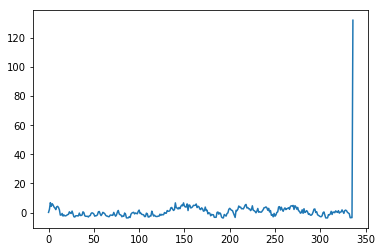

In [85]:
plt.plot(H[:, 2, 0])

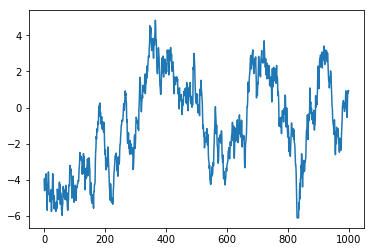

In [8]:
plt.plot(np.abs([autocovariance(H-mu, tau=t) for t in range(199)]), label='$\epsilon=%.3f$' % eps)

In [61]:
sess = tf.Session()

def get_hmc_samples(eps, steps=200, samples=None):
    hmc_dynamics = Dynamics(x_dim, gaussian.get_energy_function(), T=5, eps=eps, hmc=True)
    hmc_x = tf.placeholder(tf.float32, shape=(None, x_dim))
    Lx, _, px, hmc_MH = propose(hmc_x, hmc_dynamics, do_mh_step=True)
    
    if samples is None:
        samples = gaussian.get_samples(n=200)
    final_samples = []
    
    for t in range(steps):
        final_samples.append(np.copy(samples))
        Lx_, px_, samples = sess.run([Lx, px, hmc_MH[0]], {hmc_x: samples})
        if np.isnan(Lx_.flatten()).sum() > 0:
            print np.round(px_, decimals=2)
    return np.array(final_samples)

In [ ]:
from utils.func_utils import get_log_likelihood
F = np.array(final_samples)
G = np.array(final_samples2)
plt.plot([get_log_likelihood(F[t, :, :], gaussian) for t in range(200)], label='Small gaussian')
plt.plot([get_log_likelihood(G[t, :, :], gaussian) for t in range(200)], label='Unit gaussian')
plt.plot([get_log_likelihood(gaussian.get_samples(200), gaussian) for t in range(200)], label='Exact sampling')
plt.xlabel('MH steps')
plt.ylabel('$E(x)$')
plt.legend()

In [ ]:
w = tf.placeholder(tf.float32, shape=(None, 5))
v = tf.placeholder(tf.float32, shape=(None, 5))

w / v

In [ ]:
sess.run(w / v, {w: [[1, 2, 3, 4, 5]], v: [[2, 2, 5, 2, 2]]})

In [11]:
steps = [500, 2500, 5000, 25000]
lower_bound = [-96, -87.40, -85.82, -84.79]

[]

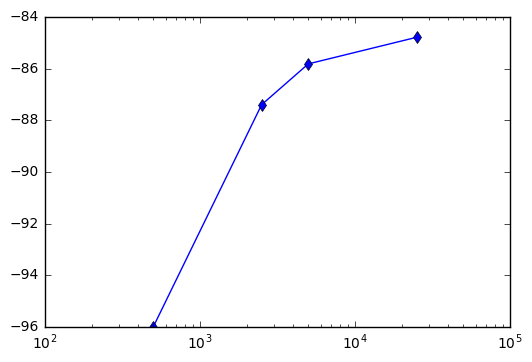

In [12]:
plt.plot(steps, lower_bound, marker='d')
plt.semilogx()

In [13]:
HMC_test = [-87.59, -85.10, -84.46]
CS_test = [-86.85, -84.56, -84.66]

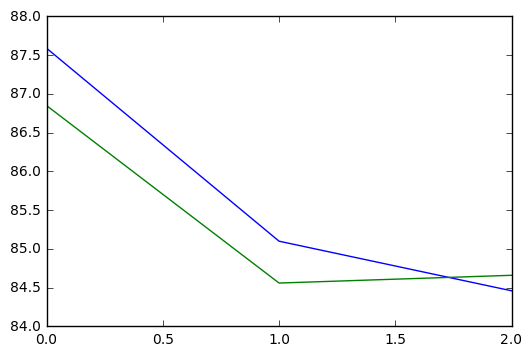

In [16]:
plt.plot(-np.array(HMC_test))
plt.plot(-np.array(CS_test))